In [ ]:
# 3/20 check point 구현 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==1.15
!pip install keras==2.2.4
!pip install keras_tqdm

In [ ]:
#!pip install tensorflow==1.15.0
import tensorflow as tf
import keras
print(tf.__version__) # 1,15,0
print(keras.__version__) # 2.2.4

1.15.0
2.2.4


Using TensorFlow backend.


In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf

# Set some parameters # 3/23 : 256,512 -> (690,1600)(X) , (688,1600)(O), (512,1024)
IMG_WIDTH = 768
IMG_HEIGHT = 1536
IMG_CHANNELS = 3

# 파일 경로 설정
drive_path='/content/drive/My Drive/Colab Notebooks/webtoon_data/png_img/'
TRAIN_PATH = drive_path # drive_path='/content/sample_data/'

TRAIN_PATH_IMG=TRAIN_PATH+'train_imgs/'
TRAIN_PATH_MASK=TRAIN_PATH+'train_masks/'

VAL_PATH_IMG=TRAIN_PATH+'val_imgs/'
VAL_PATH_MASK=TRAIN_PATH+'val_masks/'


TEST_PATH = drive_path
TEST_PATH_IMG=TEST_PATH+'test_imgs/' # 예측할 데이터 파일



In [ ]:
from PIL import Image
import cv2

X_DIR = TRAIN_PATH_IMG #TRAIN_PATH_IMG
Y_DIR = TRAIN_PATH_MASK #VAL_PATH_MASK 

x_files = sorted(os.listdir(X_DIR))
y_files = sorted(os.listdir(Y_DIR))

In [ ]:
print(len(x_files))
print(len(y_files))


839
839


In [ ]:

for n in range(len(x_files)):
    if(n<10):
        print(n, ":",x_files[n],',',y_files[n])


0 : 01_001.png , 01_001_mask.png
1 : 02_002.png , 02_002_mask.png
2 : 03_003.png , 03_003_mask.png
3 : 04_004.png , 04_004_mask.png
4 : 05_005.png , 05_005_mask.png
5 : 05_006.png , 05_006_mask.png
6 : 06_006.png , 06_006_mask.png
7 : 07_007.png , 07_007_mask.png
8 : 08_008.png , 08_008_mask.png
9 : 09_009.png , 09_009_mask.png


In [ ]:
arrs_x = []
arrs_y = []

# 전처리
for i, (xf_name, yf_name) in enumerate(zip(x_files,y_files)):
    #print(xf_name[:-4],' <> ',yf_name[:-9])
    #im_x = Image.open(X_DIR+'/'+xf_name).convert('RGB')
    #im_x = im_x.resize((512,1024))
    #im_x = np.array(im_x)
    #arrs_x.append(im_x)
    
    im_y = Image.open(Y_DIR+'/'+yf_name)
    im_y = im_y.resize((512,1024)).convert('L')
    im_y = np.expand_dims(im_y, axis=-1)
    im_y = np.array(im_y)
    arrs_y.append(im_y)
    
#x = np.array(arrs_x)
y = np.array(arrs_y)


In [ ]:
arrs_x = []
arrs_y = []

# 전처리
for i, (xf_name, yf_name) in enumerate(zip(x_files,y_files)):
    print(xf_name[:-4],' <> ',yf_name[:-9])
    im_x = cv2.imread(X_DIR+'/'+xf_name,cv2.IMREAD_COLOR)
    im_x = cv2.cvtColor(im_x, cv2.COLOR_BGR2RGB)
    im_x = cv2.resize(im_x,(IMG_WIDTH,IMG_HEIGHT),interpolation=cv2.INTER_AREA)
    im_x = np.array(im_x)
    arrs_x.append(im_x)
    
    im_y = cv2.imread(Y_DIR+'/'+yf_name,cv2.IMREAD_GRAYSCALE)
    im_y = cv2.resize(im_y,(IMG_WIDTH,IMG_HEIGHT),interpolation=cv2.INTER_AREA)
    im_y = np.expand_dims(im_y, axis=-1)
    im_y = np.array(im_y)
    arrs_y.append(im_y)
    
x = np.array(arrs_x)
y = np.array(arrs_y)


53_053  <>  53_053
54_054  <>  54_054
55_055  <>  55_055
56_056  <>  56_056
57_057  <>  57_057
58_058  <>  58_058
59_059  <>  59_059
60_060  <>  60_060
61_061  <>  61_061
62_062  <>  62_062
63_063  <>  63_063
64_064  <>  64_064
65_065  <>  65_065
66_066  <>  66_066
67_067  <>  67_067
68_068  <>  68_068
69_069  <>  69_069
70_070  <>  70_070
71_071  <>  71_071
72_072  <>  72_072
73_073  <>  73_073
74_074  <>  74_074
75_075  <>  75_075
76_076  <>  76_076
77_077  <>  77_077
78_078  <>  78_078
79_079  <>  79_079
80_080  <>  80_080
81_081  <>  81_081
82_082  <>  82_082
83_083  <>  83_083
84_084  <>  84_084
85_085  <>  85_085
86_086  <>  86_086
87_087  <>  87_087
88_088  <>  88_088
89_089  <>  89_089
90_090  <>  90_090
91_091  <>  91_091
92_092  <>  92_092
93_093  <>  93_093
94_094  <>  94_094
95_095  <>  95_095
96_096  <>  96_096
97_097  <>  97_097
98_098  <>  98_098
99_099  <>  99_099


In [ ]:
print(x.shape)
print(y.shape)


(839, 1536, 768, 3)
(839, 1536, 768, 1)


In [ ]:
npy_path = '/content/drive/My Drive/Colab Notebooks/webtoon_data/npy_data/1536_768/'
np.save(npy_path+'x_train',x)
np.save(npy_path+'y_train',y)
#np.save(npy_path+'x_val',x)
#np.save(npy_path+'y_val',y)

In [ ]:
x_train_load = np.load(npy_path+'x_train.npy')
y_train_load = np.load(npy_path+'y_train.npy')

#x_val_load = np.load(npy_path+'x_val.npy')
#y_val_load = np.load(npy_path+'y_val.npy')

print(x_train_load.shape)
print(y_train_load.shape)

#print(x_val_load.shape) 
#print(y_val_load.shape)


(839, 1536, 768, 3)
(839, 1536, 768, 1)


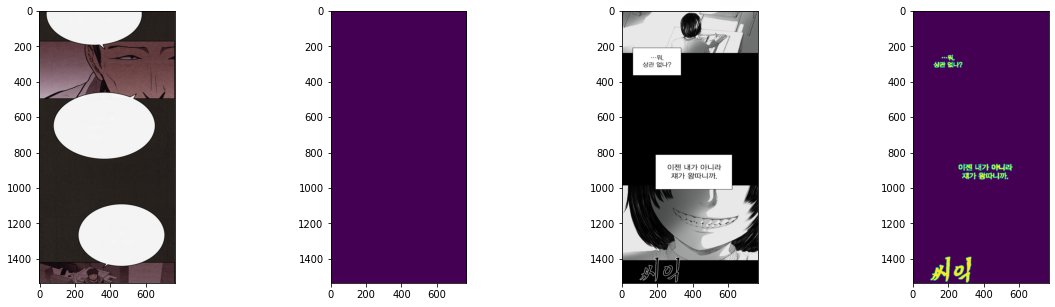

In [ ]:
import matplotlib.pyplot as plt

ix = random.randint(0, len(x_train_load))
tx = random.randint(0, len(x_train_load))

_,axes = plt.subplots(1,4, figsize=(20,5))

axes[0].imshow(x_train_load[ix])
axes[1].imshow(np.squeeze(y_train_load[ix]))
axes[2].imshow(x_train_load[tx])
axes[3].imshow(np.squeeze(y_train_load[tx]))

plt.show()


In [ ]:
y_train_load[ix].shape

(1024, 512)

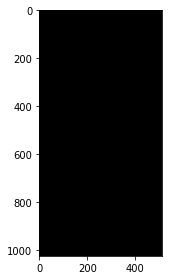

In [ ]:
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
#y = np.squeeze(y_train_load)
ix = random.randint(0, len(y))
#imshow(x[ix])
#plt.show()
imshow(y[ix])
plt.show()

In [ ]:
y[ix].shape

(1024, 512)